# CNN practice

1. simple CNN
2. deep CNN
3. ?
4. ?
5. ensemble
6. low memory

In [65]:
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

from mnist import MNIST

# Load Image

In [66]:
mndata = MNIST('../data/mnist/')

train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

train_images = np.array(train_images).reshape((-1, 28, 28, 1))
train_labels = np.array(train_labels)
test_images = np.array(test_images).reshape((-1, 28, 28, 1))
test_labels = np.array(test_labels)

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

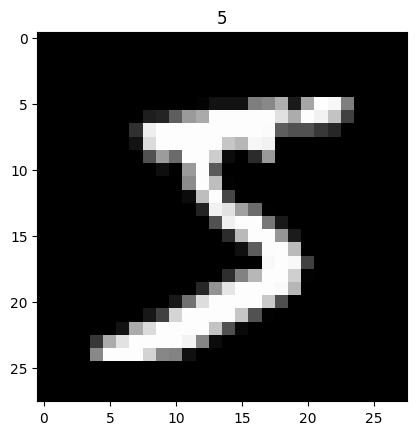

In [67]:
idx = 0

plt.title(train_labels[0])
plt.imshow(train_images[0], cmap='gray')
plt.show()

In [68]:
train_labels_1hot = tf.one_hot(train_labels, 10)
test_labels_1hot = tf.one_hot(test_labels, 10)

train_labels_1hot.shape, test_labels_1hot.shape

(TensorShape([60000, 10]), TensorShape([10000, 10]))

# Simple CNN

5 layers (last FC-10)

In [88]:
def conv_block(x, filter_nums, dropout_rate, name, weights=None):
    if weights:
        print(weights)
        filters = weights
    else:
        filters = tf.Variable(tf.random.normal([3, 3, 1, filter_nums]))
    conv_output = tf.nn.conv2d(x, filters, (1,1,1,1), 'SAME', name=name)
    relu_output = tf.nn.relu(conv_output)
    pool_output = tf.nn.max_pool2d(
        relu_output, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')
    block_output = tf.nn.dropout(pool_output, rate=dropout_rate)
    return block_output, filters

def fc_layer(x, units, weights=None):
    if weights:
        w, b = weights
    else:
        w = tf.Variable(tf.random.normal((x.shape[-1], units)))
        b = tf.Variable(tf.random.normal((units, )))
    fc_output = tf.nn.relu(tf.matmul(x, w)+b)
    return fc_output, [w, b]

def last_layer(x, classes, weights=None):
    if weights:
        w, b = weights
    else:
        w = tf.Variable(tf.random.normal((x.shape[-1], classes)))
        b = tf.Variable(tf.random.normal((classes, )))
    logits = tf.matmul(x, w)+b
    return logits, [w, b]#tf.nn.softmax(logits)
    

def model(x, dropout_rate, weights=None):
    if not weights:
        # convolution blocks
        l1_output, w1 = conv_block(x, 32, dropout_rate, 'conv1')
        # print("l1 output shape: ", l1_output.shape)
        l2_output, w2 = conv_block(l1_output, 64, dropout_rate, 'conv2')
        # print("l2 output shape: ", l2_output.shape)
        l3_output, w3 = conv_block(l2_output, 128, dropout_rate, 'conv3')
        # print("l3 output shape: ", l3_output.shape)

        # fc layers
        flatten = tf.reshape(l3_output, (x.shape[0], -1))
        # print("flatten output shape: ", flatten.shape)
        l4_output, w4 = fc_layer(flatten, 4096)
        # print("l4 output shape: ", l4_output.shape)
        l5_output, w5 = fc_layer(l4_output, 4096)
        # print("l5 output shape: ", l5_output.shape)
        l6_output, w6 = last_layer(l5_output, 10)
    else:
        # convolution blocks
        l1_output, w1 = conv_block(x, 32, dropout_rate, 'conv1', weights=weights[0])
        # print("l1 output shape: ", l1_output.shape)
        l2_output, w2 = conv_block(l1_output, 64, dropout_rate, 'conv2', weights=weights[1])
        # print("l2 output shape: ", l2_output.shape)
        l3_output, w3 = conv_block(l2_output, 128, dropout_rate, 'conv3', weights=weights[2])
        # print("l3 output shape: ", l3_output.shape)

        # fc layers
        flatten = tf.reshape(l3_output, (x.shape[0], -1))
        # print("flatten output shape: ", flatten.shape)
        l4_output, w4 = fc_layer(flatten, 4096, weights=weights[3])
        # print("l4 output shape: ", l4_output.shape)
        l5_output, w5 = fc_layer(l4_output, 4096, weights=weights[4])
        # print("l5 output shape: ", l5_output.shape)
        l6_output, w6 = last_layer(l5_output, 10, weights=weights[5])

    weights = [w1, w2, w3, w4, w5, w6]
    return l6_output, weights
    

In [87]:
output, weights = model(test_images, 0.01)

None


In [90]:
learning_rate = 0.0001
sgd = tf.keras.optimizers.legacy.SGD(learning_rate)

In [91]:
epochs = 5

weights = ''
for i in range(epochs):

    with tf.GradientTape() as tape:
        if len(weights):
            pred, _ = model(train_images, 0.01, weights)
        else:
            pred, weights = model(train_images, 0.01)
        loss = tf.nn.softmax_cross_entropy_with_logits(train_labels_1hot, pred)

    sgd.minimize(loss, var_list=weights, tape=tape)
    print(f"epoch: {i}, loss: {loss}")

InvalidArgumentError: {{function_node __wrapped__Conv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:CPU:0}} Gradients for grouped convolutions are not supported on CPU. Please file a feature request if you run into this issue. Computed input depth 64 doesn't match filter input depth 1 [Op:Conv2DBackpropInput] name: 